In [124]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def read_data(filename = '../data/global_irradiance_daily_aurora.csv'):
    df_temp = pd.read_csv(
        filename,
        sep=';',  # Usando ponto e vírgula como separador
        parse_dates=['Data'],  # Indicando que 'Data' deve ser interpretado como data
        index_col=['Data']  # Usando 'Data' como índice
    )

    # Renomeando a coluna 'Medicao' para 'RADIATION' para manter a consistência
    df_temp.rename(columns={'Medicao': 'RADIATION'}, inplace=True)

    init_index = lambda _df: _df[_df.RADIATION != 0].index[0]

    return df.loc[df.index >= init_index(df)]

def interpolate_filler(data):
    return data.interpolate(method ='linear', limit_direction ='backward')

def fill_df(dataframe, filler):
    data = {}
    for column in dataframe.columns:
        data[column] = filler(dataframe[column])
    return pd.DataFrame(data=data, index=dataframe.index.values)

def windowing(dataframe, step_back, step_front) -> (np.array, np.array):
    dataset = dataframe.values
    x, y = [], []
    for i in range(len(dataset) - step_back - step_front):
        j = (i + step_back)
        x.append(dataset[i:j])
        y.append(dataset[j:(j+step_front), 0])

    return np.array(x), np.array(y)

def split_data(x, y, length, ratio=0.8):
    train_size = int(length * 0.9)
    _train_x, _train_y = x[0:train_size], y[0:train_size].reshape(y[0:train_size].shape[0],)
    _test_x, _test_y = x[train_size:], y[train_size:].reshape(y[train_size:].shape[0],)
    return _train_x, _train_y, _test_x, _test_y

def show_error_metrics(real, pred):
    r2 = r2_score(real, pred)
    mse = mean_squared_error(real, pred)
    rmse = sqrt(mean_squared_error(real, pred))
    mae = mean_absolute_error(real, pred)
    mape = mean_absolute_percentage_error(real, pred)

    print('Test R2: %.3f' % r2)
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: %.3f' % mae)
    print('Test MAPE: %.3f' % mape)

In [126]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units',
                                       min_value=32,
                                       max_value=512,
                                       step=32),
                          return_sequences=True,
                          input_shape=(3, 1)))  # Ajustado para a nova forma dos dados
    model.add(layers.Dropout(rate=hp.Float(
        'dropout',
        min_value=0.0,
        max_value=0.5,
        default=0.25,
        step=0.05,
    )))
    model.add(layers.LSTM(units=hp.Int('units_2',
                                       min_value=32,
                                       max_value=512,
                                       step=32)))
    model.add(layers.Dense(1, activation=hp.Choice('activation', ['relu', 'sigmoid'])))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])))
    return model

def model_search(
        name,
        train_x,
        train_y,
        max_trials=10,
        executions_per_trial=1,
        epochs=10,
        validation_split=0.3
):
    tuner = RandomSearch(
        build_model,
        seed=13418236482,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='models',
        project_name=name)

    tuner.search_space_summary()

    tuner.search(train_x, train_y,
                 epochs=epochs,
                 validation_split=validation_split)

    return tuner.get_best_hyperparameters()[0]

In [127]:
class Scaler:
    scales: {}
    df: pd.DataFrame
    df_scaled: pd.DataFrame
    scaled: bool

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.scales = {}
        for c in df.columns:
            self.scales[c] = MinMaxScaler(feature_range=(0, 1))
        self.scaled = False

    def get_dataframe_scaled(self):
        if self.scaled:
            return self.df_scaled
        self.scaled = True
        self.df_scaled = self.df.copy()
        for c in df.columns:
            self.df_scaled[c] = self.scales[c]\
                .fit_transform(self.df_scaled[c].values.reshape(-1, 1))
        return self.df_scaled

In [128]:
df = read_data()

In [129]:
print(df.size)
df = fill_df(df, interpolate_filler)

7332


In [130]:
scaler = Scaler(df)
df_scaled = scaler.get_dataframe_scaled()
print(df, df_scaled)

            RADIATION
2002-12-05    17306.0
2002-12-06    17306.0
2002-12-07    17306.0
2002-12-08    17306.0
2002-12-09    17306.0
...               ...
2022-12-27    13899.2
2022-12-28    10267.3
2022-12-29     8122.0
2022-12-30     7987.6
2022-12-31    12501.4

[7332 rows x 1 columns]             RADIATION
2002-12-05   0.543153
2002-12-06   0.543153
2002-12-07   0.543153
2002-12-08   0.543153
2002-12-09   0.543153
...               ...
2022-12-27   0.435906
2022-12-28   0.321572
2022-12-29   0.254037
2022-12-30   0.249806
2022-12-31   0.391903

[7332 rows x 1 columns]


In [131]:
X, Y = windowing(df_scaled, 3, 1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)

## LSTM

In [132]:
hp = model_search('interpolate_lstm_5_1_aurora', train_x, train_y, 20, 3, 10, 0.3)
hp.values

Reloading Tuner from models\interpolate_lstm_5_1_aurora\tuner0.json
Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


{'units': 32,
 'dropout': 0.05,
 'units_2': 512,
 'activation': 'sigmoid',
 'learning_rate': 0.01}

Epoch 1/200
92/92 - 4s - loss: 0.0249 - val_loss: 0.0210 - 4s/epoch - 44ms/step
Epoch 2/200
92/92 - 1s - loss: 0.0220 - val_loss: 0.0188 - 1s/epoch - 16ms/step
Epoch 3/200
92/92 - 1s - loss: 0.0221 - val_loss: 0.0221 - 1s/epoch - 16ms/step
Epoch 4/200
92/92 - 1s - loss: 0.0219 - val_loss: 0.0233 - 1s/epoch - 16ms/step
Epoch 5/200
92/92 - 2s - loss: 0.0219 - val_loss: 0.0213 - 2s/epoch - 17ms/step
Epoch 6/200
92/92 - 2s - loss: 0.0219 - val_loss: 0.0202 - 2s/epoch - 16ms/step
Epoch 7/200
92/92 - 1s - loss: 0.0217 - val_loss: 0.0186 - 1s/epoch - 16ms/step
Epoch 8/200
92/92 - 1s - loss: 0.0214 - val_loss: 0.0256 - 1s/epoch - 16ms/step
Epoch 9/200
92/92 - 1s - loss: 0.0219 - val_loss: 0.0217 - 1s/epoch - 16ms/step
Epoch 10/200
92/92 - 1s - loss: 0.0214 - val_loss: 0.0212 - 1s/epoch - 16ms/step
Epoch 11/200
92/92 - 1s - loss: 0.0216 - val_loss: 0.0194 - 1s/epoch - 16ms/step
Epoch 12/200
92/92 - 1s - loss: 0.0212 - val_loss: 0.0199 - 1s/epoch - 15ms/step
Epoch 13/200
92/92 - 1s - loss: 0.021

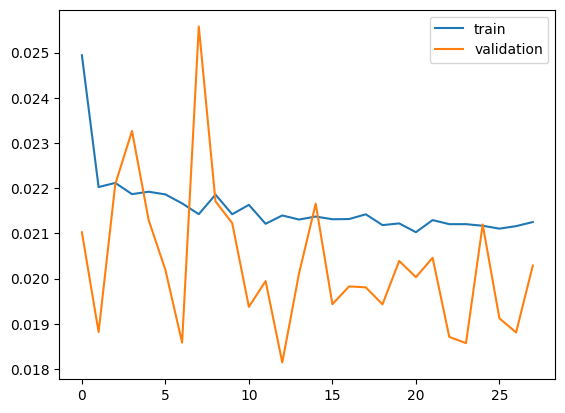

In [133]:
model = build_model(hp)

# fit network
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(train_x,
                    train_y,
                    epochs=200,
                    batch_size=72,
                    validation_data=(test_x, test_y),
                    validation_split=0.3,
                    verbose=2,
                    callbacks=[es],
                    workers=4,
                    use_multiprocessing=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [134]:
predict = model.predict(test_x)

real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

23/23 [==============================] - 1s 5ms/step


Test R2: 0.481
Test MSE: 20473077.180
Test RMSE: 4524.718
Test MAE: 3666.034
Test MAPE: 0.378


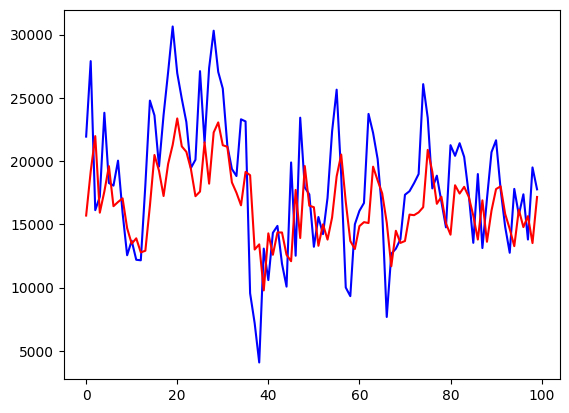

In [135]:
range_plot = 100

pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

pyplot.show()

## Manual Model

In [136]:
print(test_x.shape, test_y.shape)

(730, 3, 1) (730,)


In [137]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping


model2 = Sequential([
    Dense(1, input_shape=(5, 3)),
    Dense(units=352),
    Dropout(rate=0.35),
    LSTM(units=320),
    Dense(1, activation='sigmoid')
])


model2.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(0.01))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model2.fit(train_x,
                     train_y,
                     epochs=200,
                     batch_size=72,
                     #validation_data=(test_x, test_y),
                     validation_split=0.3,
                     verbose=2,
                     callbacks=[es],
                     workers=4,
                     use_multiprocessing=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/200


ValueError: in user code:

    File "C:\Users\pedr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\pedr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\pedr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\pedr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\pedr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\pedr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 5, 3), found shape=(None, 3, 1)


In [ ]:
model2.evaluate(test_x, test_y, verbose=1)

In [ ]:
predict = model2.predict(test_x)


real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

In [ ]:
range_plot = 100

pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

pyplot.show()